In [3]:
import tensorflow as tf
import keras
from keras import backend as bk
import timeit

from scipy.integrate import ode
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import random as rdm
import time
from datetime import datetime
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Model

In [81]:
class custom_model:

    def __init__(self):
        xavier=tf.keras.initializers.GlorotUniform()
        self.l1=tf.keras.layers.Dense(3,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l2=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l3=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l4=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l5=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l6=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l7=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.out=tf.keras.layers.Dense(1,kernel_initializer=xavier)
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=0.01)

    # Running the model

    def run(self, X):
        #with tf.device('/cpu:0'):
        boom = self.l1(X)
        boom1 = self.l2(boom)
        boom2 = self.l3(boom1)
        boom3 = self.l4(boom2)
        boom4 = self.l5(boom3)
        boom5 = self.l6(boom4)
        boom6 = self.l7(boom5)
        boom7 = self.out(boom6)
        return boom7

    def get_loss(self, Xf, XuI, XuB, YI, YB):
    
        with tf.GradientTape() as tape:
            tape.watch(Xf)
            
            with tf.GradientTape() as tape1:
                tape1.watch(Xf)
                boom = self.l1(Xf)
                boom1 = self.l2(boom)
                boom2 = self.l3(boom1)
                boom3 = self.l4(boom2)
                boom4 = self.l5(boom3)
                boom5 = self.l6(boom4)
                boom6 = self.l7(boom5)
                boom7 = self.out(boom6)
                g = tape1.gradient(boom7, Xf)
            gg = tape.gradient(g, Xf)
    
        u_t = g[:, 0]
        u_x = g[:, 1]
        u_y = g[:, 2]

        u_tt = gg[:, 0]
        u_xx = gg[:, 1]
        u_yy = gg[:, 2]

        u = boom7[:, 0]
        
        #print('u_t: ', u_t)
        #print('u_x: ', u_x)
        #print('u_xx: ', u_xx)
        #print('u: ', u)
        
        
        MSEf = tf.reduce_mean((u_tt - u_xx - u_yy)**2)
        
        Y_I_predict = self.run(XuI)
        
        ######### Dirichlet boundary conditions #########
        Y_B_predict = self.run(XuB)
        MSEu =  tf.reduce_mean((Y_I_predict - YI)**2) + tf.reduce_mean((Y_B_predict - YB)**2)
        
        ######### Neumann boundary conditions #########
        #Y_B_predict = g[:, 1]
        #MSEu =  tf.reduce_mean((Y_B_predict - YB)**2) #tf.reduce_mean((Y_I_predict - YI)**2) +
        
        return 3*MSEu + MSEf

    def get_grad(self, Xf, XuI, XuB, YI, YB):
        with tf.GradientTape() as tape:
            tape.watch(self.l1.variables)
            tape.watch(self.l2.variables)
            tape.watch(self.l3.variables)
            tape.watch(self.l4.variables)
            tape.watch(self.l5.variables)
            tape.watch(self.l6.variables)
            tape.watch(self.l7.variables)
            tape.watch(self.out.variables)
            L = self.get_loss(Xf, XuI, XuB, YI, YB)
            g = tape.gradient(L, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.l4.variables[0],self.l4.variables[1],self.l5.variables[0],self.l5.variables[1],self.l6.variables[0],self.l6.variables[1],self.l7.variables[0],self.l7.variables[1],self.out.variables[0],self.out.variables[1]])
        return g

    # perform gradient descent

    def network_learn(self, Xf, XuI, XuB, YI, YB):
        g = self.get_grad(Xf, XuI, XuB, YI, YB)
        self.train_op.apply_gradients(zip(g, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.l4.variables[0],self.l4.variables[1],self.l5.variables[0],self.l5.variables[1],self.l6.variables[0],self.l6.variables[1],self.l7.variables[0],self.l7.variables[1],self.out.variables[0],self.out.variables[1]]))


### Model

In [87]:
Model = custom_model()

### Training Set

In [88]:
N_initial = 20000
N_boundary = 10000
N_collocation = 10000

I_points = tf.constant([[0 , rdm.randrange(-1000, 1001, 1)*0.001, rdm.randrange(-1000, 1001, 1)*0.001] for i in range(N_initial)])
B_points = tf.constant([[rdm.randrange(0, 1000, 1)*0.001, rdm.randrange(-1,2,2), rdm.randrange(-1000, 1001, 1)*0.001] for i in range(N_boundary)])
B_points = tf.concat([B_points, tf.constant([[rdm.randrange(0, 1000, 1)*0.001, rdm.randrange(-1000, 1001, 1)*0.001, rdm.randrange(-1,2,2)] for i in range(N_boundary)])], 0)
C_points = tf.constant([[rdm.randrange(1, 1000, 1)*0.001, rdm.randrange(-999, 1000, 1)*0.001, rdm.randrange(-999, 1000, 1)*0.001] for i in range(N_collocation)])

### Plot The Training Set

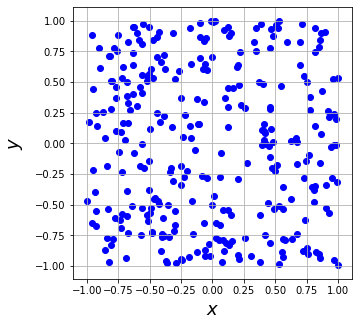

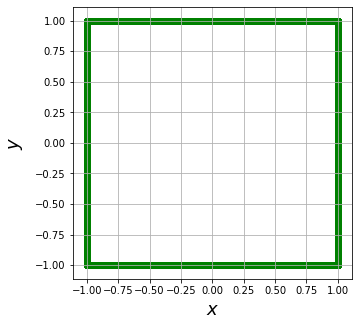

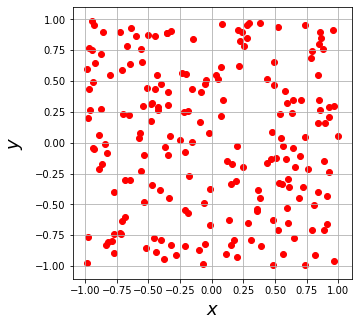

In [7]:
plt.figure(figsize=(5, 5))
plt.scatter(I_points[:300, 1], I_points[:300, 2], color='b')
plt.xlabel("$x$", fontsize=18, labelpad=5)
plt.ylabel("$y$", fontsize=18, labelpad=10)
plt.grid()
plt.figure(figsize=(5, 5))
plt.scatter(B_points[:, 1], B_points[:, 2], color='g')
plt.xlabel("$x$", fontsize=18, labelpad=5)
plt.ylabel("$y$", fontsize=18, labelpad=10)
plt.grid()
plt.figure(figsize=(5, 5))
plt.scatter(C_points[:200, 1], C_points[:200, 2], color='r')
plt.xlabel("$x$", fontsize=18, labelpad=5)
plt.ylabel("$y$", fontsize=18, labelpad=10)
plt.grid()
plt.show()

In [90]:
#Sin(x)^2
#YI = [[tf.math.sin(mt.pi*i[1])**2] for i in I_points]

def init(x,y):
    
    return 3*mt.cos(mt.pi*x/2)*mt.cos(mt.pi*y/2)*mt.sin(mt.pi*x/2)*mt.sin(mt.pi*y/2)

YI = [[init(i[1:][0], i[1:][1])] for i in I_points]
YB = [[0.] for i in B_points]

#plt.figure(figsize=(8, 8))

### Plot The Training Set

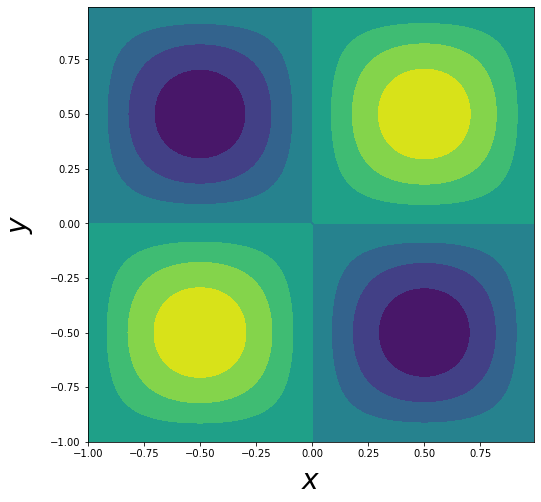

In [76]:
H = []
for j in range(-100, 100):
    h=[]
    for i in range(-100, 100):
        h.append(init(i*0.01,j*0.01))
    H.append(h)

x = np.arange(-1, 1, 0.01)
y = np.arange(-1, 1, 0.01)

z = np.array(H)

plt.figure(figsize=(8, 8))
plt.xlabel("$x$", fontsize=28, labelpad=8)
plt.ylabel("$y$", fontsize=28, labelpad=15)
plt.contourf(x,y,z)

### Training

In [94]:
start = timeit.default_timer()
epochs = 1000
Loss = []
for i in range(epochs):
    C_points = tf.constant([[rdm.randrange(1, 1000, 1)*0.001, rdm.randrange(-999, 1000, 1)*0.001, rdm.randrange(-999, 1000, 1)*0.001] for i in range(N_collocation)])
    Model.network_learn(C_points, I_points, B_points, YI, YB)
    if i % 1 == 0:
        #print((i/10000)*100, '%')
        loss = Model.get_loss(C_points, I_points, B_points, YI, YB).numpy()
        Loss.append(loss)
        #print('Loss: ', Model.get_loss(C_points, I_points, B_points, YI, YB).numpy())
    if i%(epochs/5)==0:
        #print((i/epochs)*100, '%')
        print((i/epochs)*100, '%', end='\r')
    print
    

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  106.35589280000022


### Plot The Loss

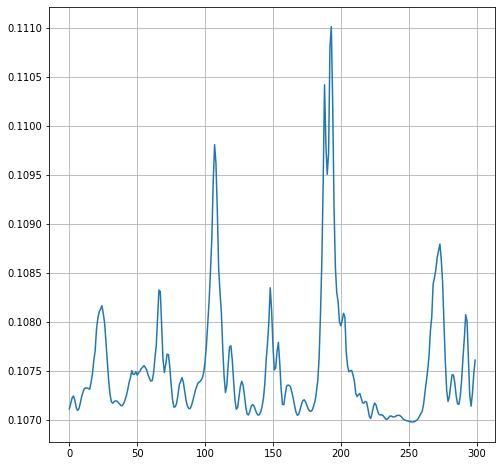

In [95]:
plt.figure(figsize=(8, 8))
plt.plot(Loss[0:300])
plt.grid()
plt.show()

### Animated Plot

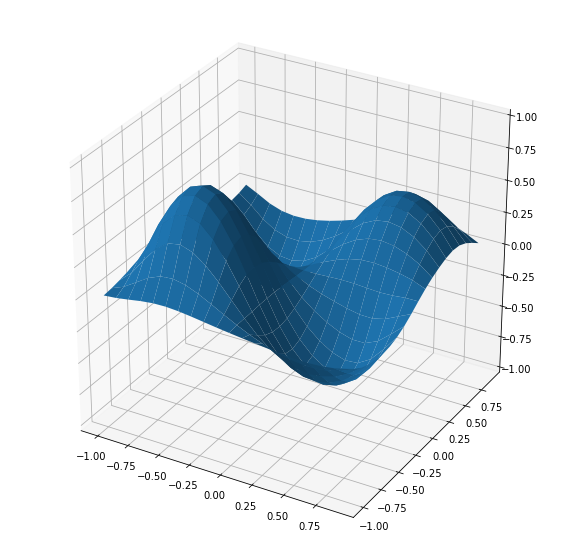

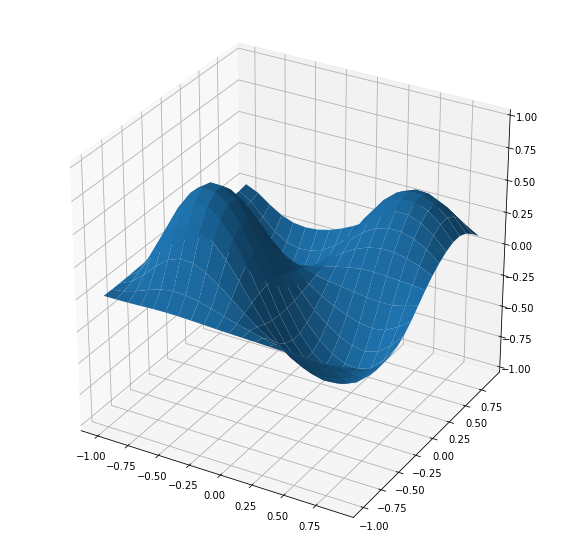

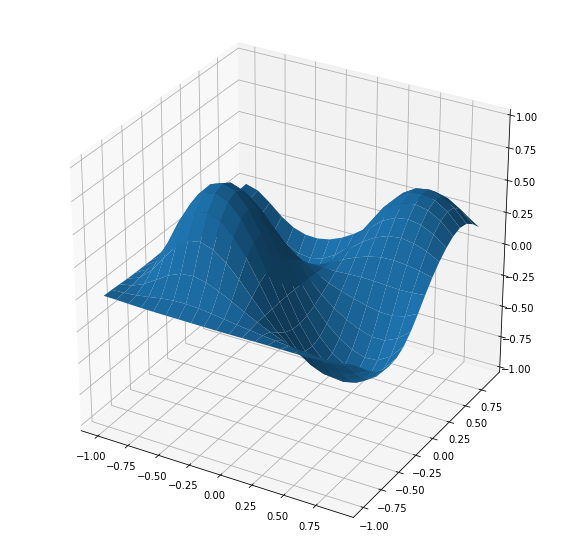

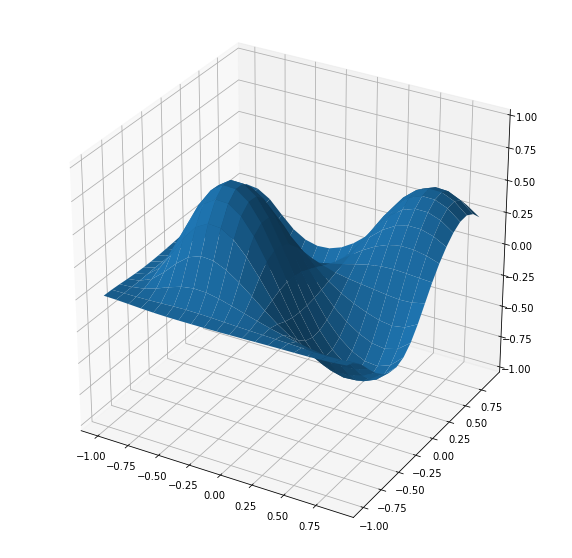

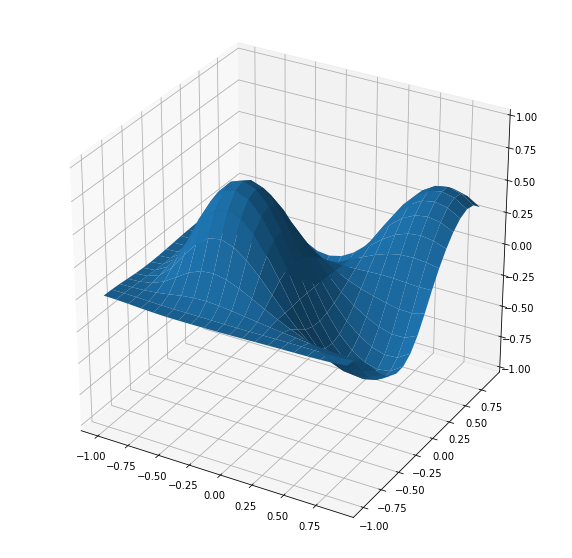

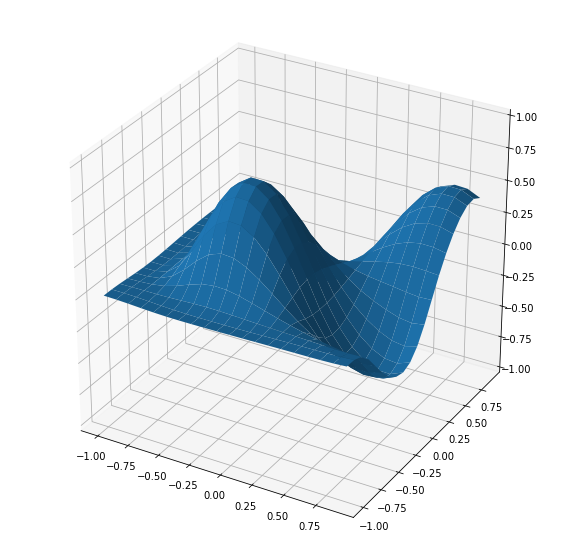

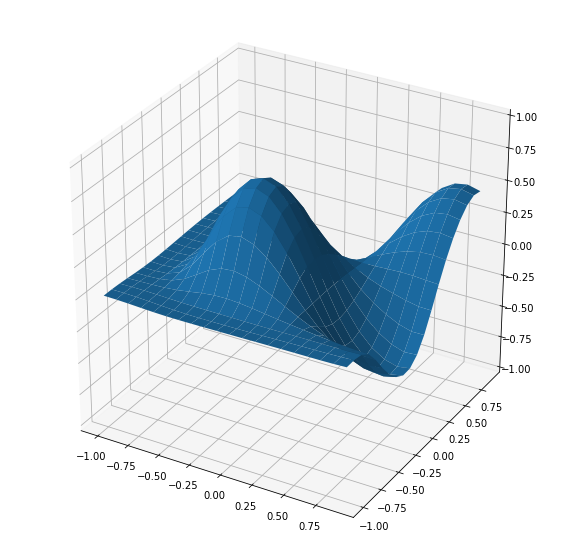

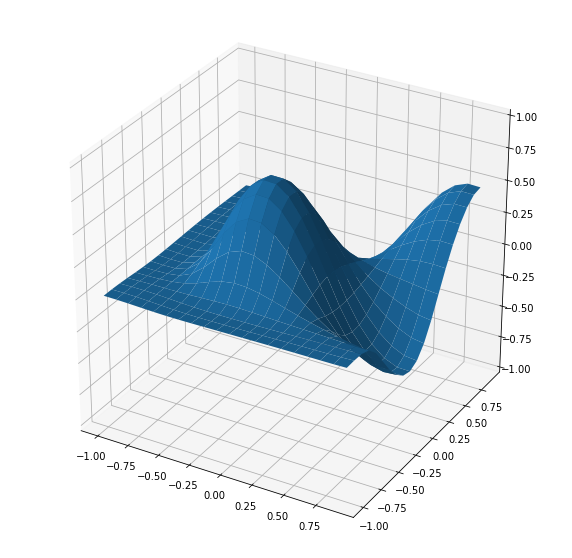

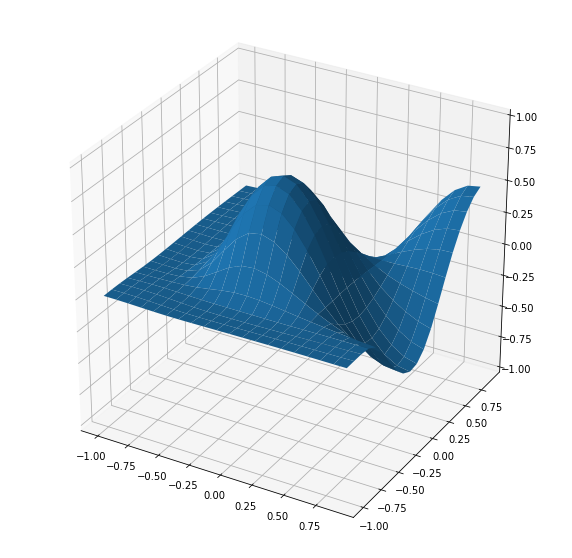

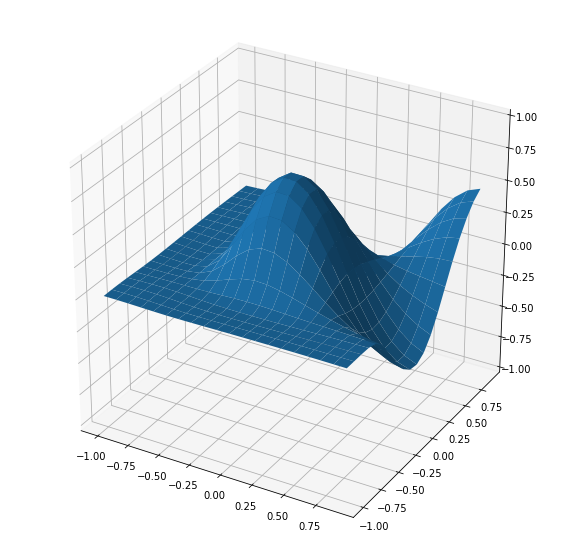

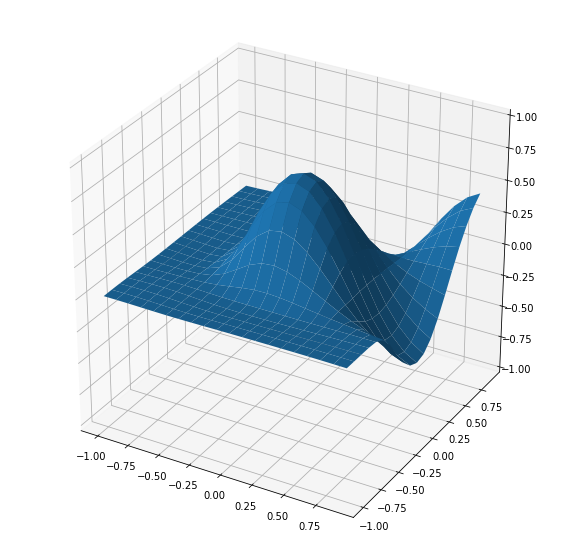

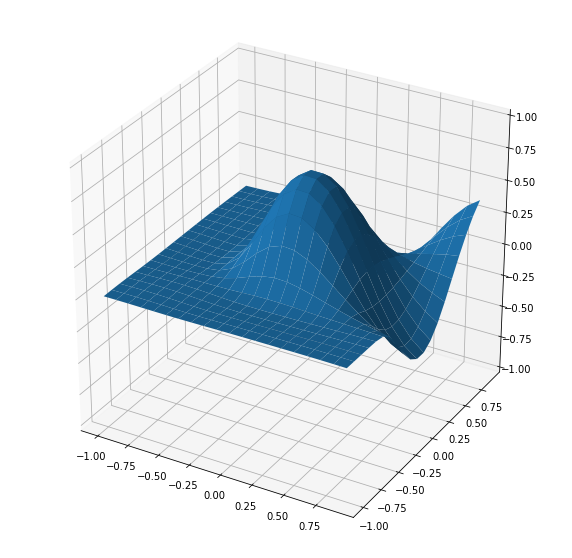

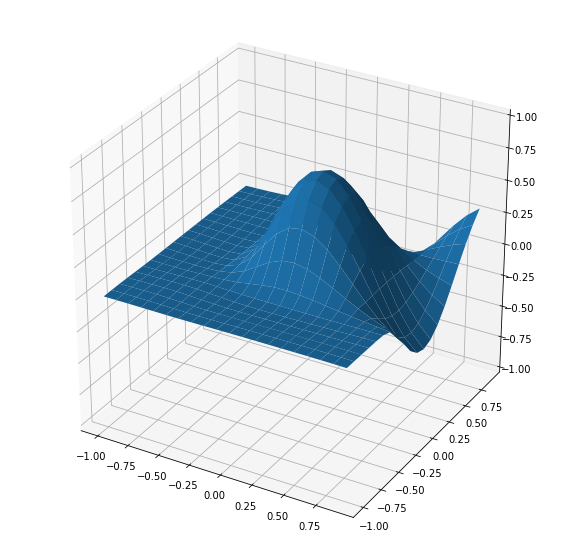

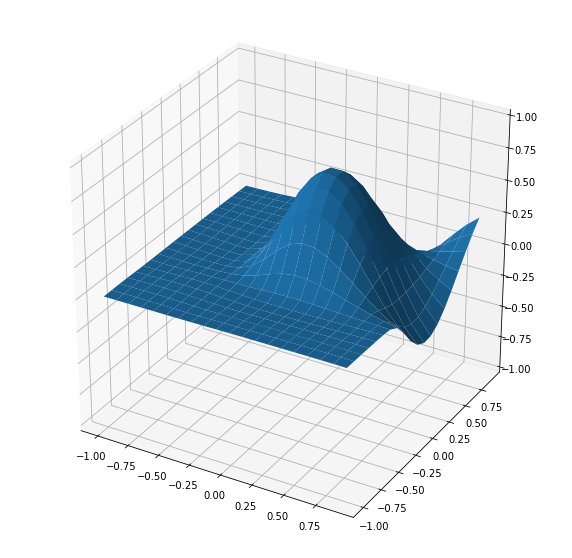

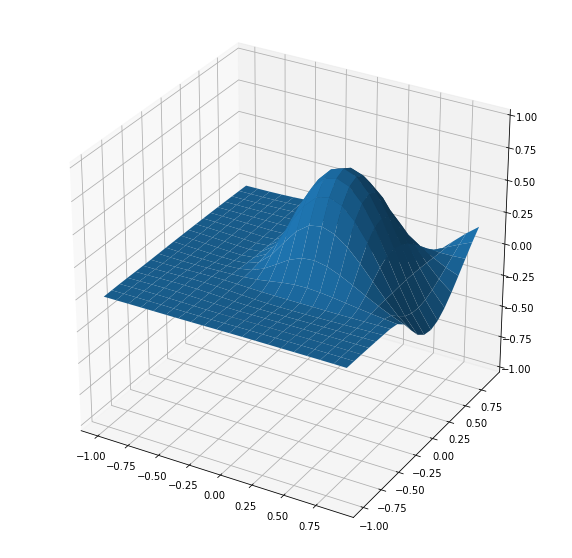

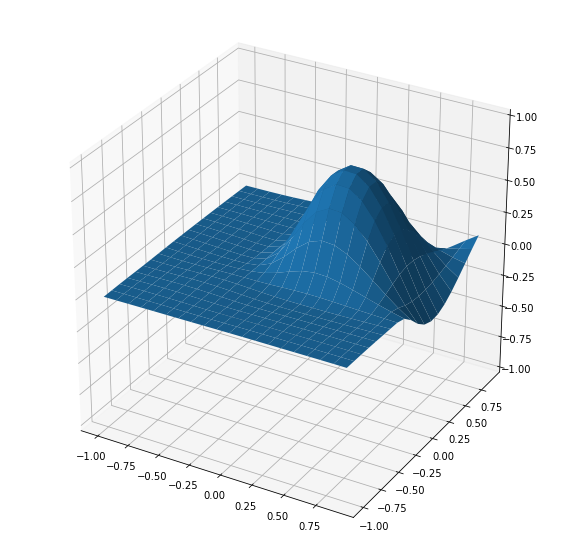

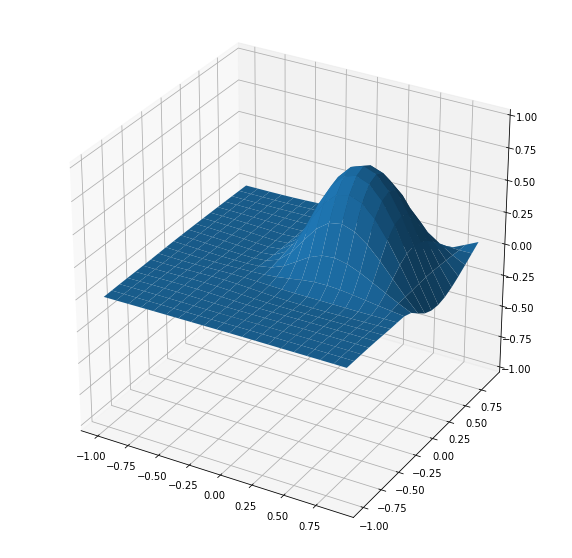

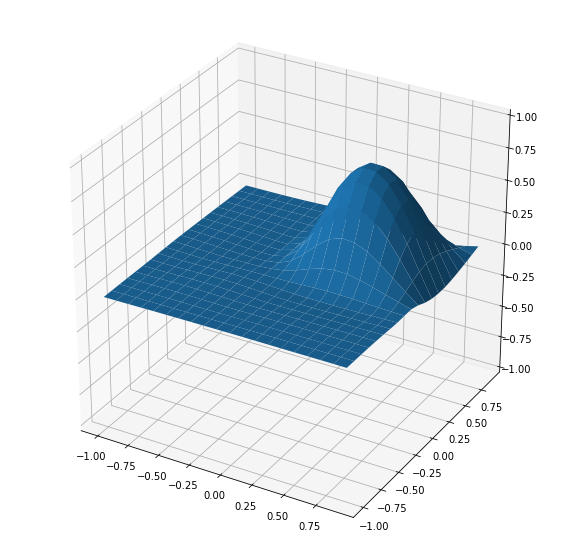

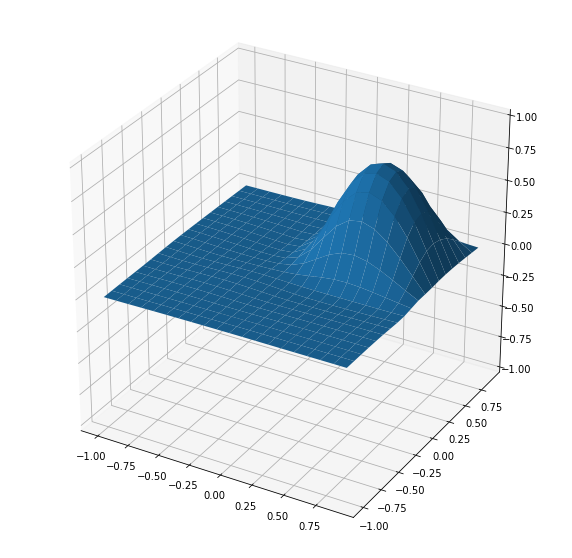

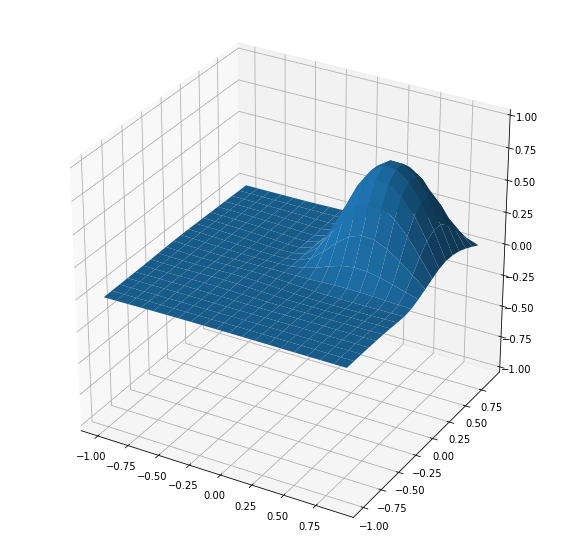

In [96]:
ims = []
T = [i*0.05 for i in range(0,20)]
x = np.arange(-1, 1, 0.1)
y = np.arange(-1, 1, 0.1)
x, y = np.meshgrid(x, y)
k = 1
for t in T:
    
    H = []
    for j in range(-10, 10):
        h=[]
        for i in range(-10, 10):
            h.append(Model.run(tf.constant([[t, i*0.1, j*0.1]]))[0][0])
        H.append(h)
    z = np.array(H)
    
    # Plot the surface.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.set_zlim(-1., 1.)
    ax.plot_surface(x, y, z)
    #ims.append(ax.plot_surface(x, y, z))
    plt.show()
    fig.savefig('Gif_folder\wave_t=' + str(k) + '.jpg')
    k=k+1

#ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
#ani.save('WaveEq.gif')